In [3]:
%load_ext lab_black

In [4]:
import os

os.chdir("/cerea_raid/users/dumontj/dev/coco2/inv")
import numpy as np
import sys
import pandas as pd
import xarray as xr
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from icecream import ic
import matplotlib_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

from typing import List, Optional

matplotlib_functions.setMatplotlibParam()
plt.viridis()
import joblib
import pickle
from include.generators import Generator
from saver import Saver
from include.callbacks import get_modelcheckpoint, ExtraValidation

import model_eval
from Data import Data_train, Data_eval
import wandb
from wandb.keras import WandbCallback, WandbMetricsLogger
import models.reg as rm

2023-11-30 14:35:30.454351: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 14:35:30.454696: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 14:35:30.458789: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 14:35:33.086056: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
wandb: ERROR Unable to patch Tensorflow/Ke

<Figure size 1920x1440 with 0 Axes>

In [5]:
path_train_nc = "/libre/dumontj/coco2/dl-input/2km_forLip_2/train_dataset.nc"
path_valid_nc = "/libre/dumontj/coco2/dl-input/2km_forLip_2/valid_dataset.nc"
path_extra_valid_nc = "/libre/dumontj/coco2/dl-input/2km_Lip/valid_dataset.nc"

In [9]:
data = Data_train(path_train_nc, path_extra_valid_nc, path_extra_valid_nc)
data.prepare_input("xco2", "u_wind", "no2")
data.prepare_output_inversion()

data.x.train.shape (25152, 64, 64, 3)


In [10]:
reg_builder = rm.Reg_model_builder(
    "essential",
    data.x.fields_input_shape,
    data.y.classes,
    data.x.norm_layer,
    data.x.noise_layer,
    cloud_layer=data.x.cloud_layer,
)
model = reg_builder.get_model()
model.compile(
    "adam", "MeanAbsoluteError", metrics=tf.keras.losses.MeanAbsolutePercentageError()
)

In [11]:
model.fit(
    data.x.train,
    data.y.train,
    epochs=100,
    validation_data=(data.x.extra_valid, data.y.extra_valid),
    verbose=1,
)

Epoch 1/100


2023-11-30 14:48:53.081203: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/model_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


786/786 [==============================] - 15s 15ms/step - loss: 4.1010 - mean_absolute_percentage_error: 32.7102 - val_loss: 4.8766 - val_mean_absolute_percentage_error: 30.6805
Epoch 2/100
786/786 [==============================] - 12s 15ms/step - loss: 3.0092 - mean_absolute_percentage_error: 23.8203 - val_loss: 3.3749 - val_mean_absolute_percentage_error: 21.8313
Epoch 3/100
786/786 [==============================] - 12s 15ms/step - loss: 2.7433 - mean_absolute_percentage_error: 21.7220 - val_loss: 4.8335 - val_mean_absolute_percentage_error: 30.2681
Epoch 4/100
786/786 [==============================] - 12s 15ms/step - loss: 2.5890 - mean_absolute_percentage_error: 20.4624 - val_loss: 4.2763 - val_mean_absolute_percentage_error: 26.6565
Epoch 5/100
786/786 [==============================] - 12s 15ms/step - loss: 2.4744 - mean_absolute_percentage_error: 19.5835 - val_loss: 4.5405 - val_mean_absolute_percentage_error: 28.6219
Epoch 6/100
786/786 [==============================] - 12


KeyboardInterrupt



In [12]:
inputs = data.x.train[0:32]

In [13]:
outputs = reg_builder.bottom_layers(inputs, training=True)

In [14]:
num_examples = 5
example_indices = np.random.choice(inputs.shape[0], num_examples, replace=False)

ic| np.sum(plot_data == np.min(plot_data)): 1
ic| np.min(plot_data): 400.2948303222656
ic| np.sum(plot_data == np.min(plot_data)): 1
ic| np.min(plot_data): 400.3013916015625
ic| np.sum(plot_data == np.min(plot_data)): 1
ic| np.min(plot_data): 400.82110595703125
ic| np.sum(plot_data == np.min(plot_data)): 1
ic| np.min(plot_data): 400.6265869140625
ic| np.sum(plot_data == np.min(plot_data)): 1
ic| np.min(plot_data): 400.620361328125


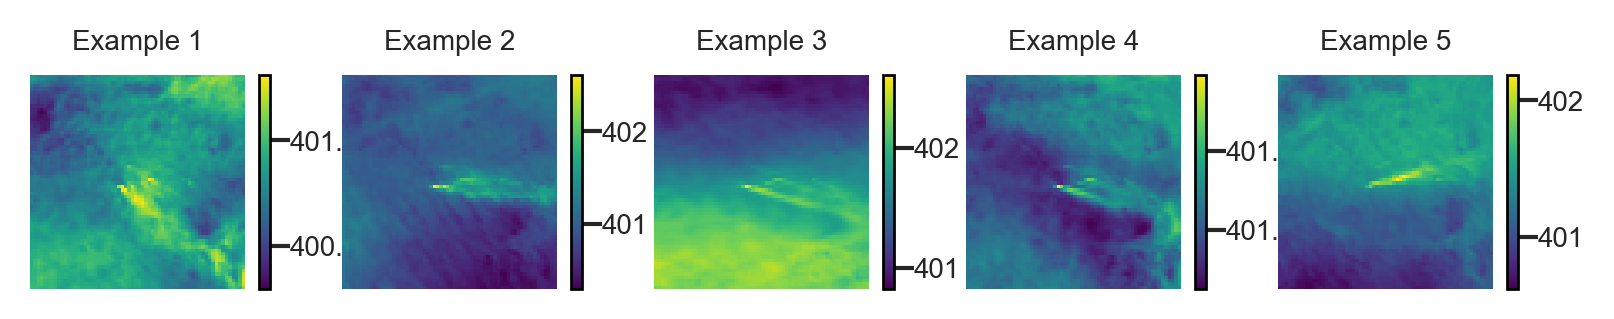

ic| np.sum(plot_data == np.median(plot_data)): 0
ic| np.median(plot_data): 2713227428681234.0
ic| np.sum(plot_data == np.median(plot_data)): 0
ic| np.median(plot_data): 3544362003493666.0
ic| np.sum(plot_data == np.median(plot_data)): 0
ic| np.median(plot_data): 4501195256171008.0
ic| np.sum(plot_data == np.median(plot_data)): 0
ic| np.median(plot_data): 3250010829195084.0
ic| np.sum(plot_data == np.median(plot_data)): 0
ic| np.median(plot_data): 6135548070298824.0


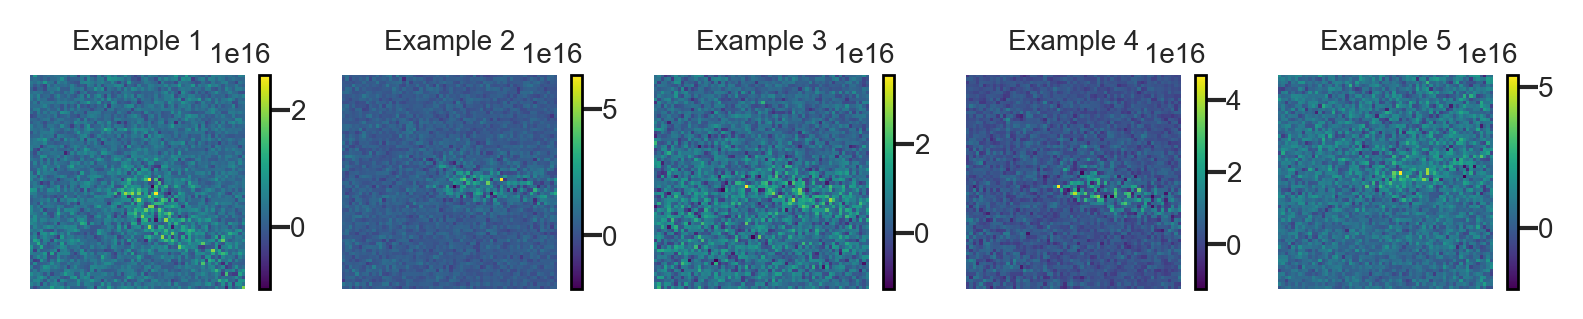

In [15]:
for i, idx in enumerate(example_indices):
    plot_data = inputs[idx, :, :, 0]

    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(plot_data, cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ic(np.sum(plot_data == np.min(plot_data)))
    plt.colorbar(im, cax=cax)
    ic(np.min(plot_data))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

for i, idx in enumerate(example_indices):
    plot_data = inputs[idx, :, :, 2]

    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(plot_data, cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ic(np.sum(plot_data == np.median(plot_data)))
    plt.colorbar(im, cax=cax)
    ic(np.median(plot_data))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

ic| np.sum(plot_data == np.min(plot_data)): 219
ic| np.min(plot_data): -4.5498257
ic| np.sum(plot_data == np.min(plot_data)): 1336
ic| np.min(plot_data): -4.5498257
ic| np.sum(plot_data == np.min(plot_data)): 1946
ic| np.min(plot_data): -4.5498257
ic| np.sum(plot_data == np.min(plot_data)): 1
ic| np.min(plot_data): -0.97250766
ic| np.sum(plot_data == np.min(plot_data)): 1794
ic| np.min(plot_data): -4.5498257


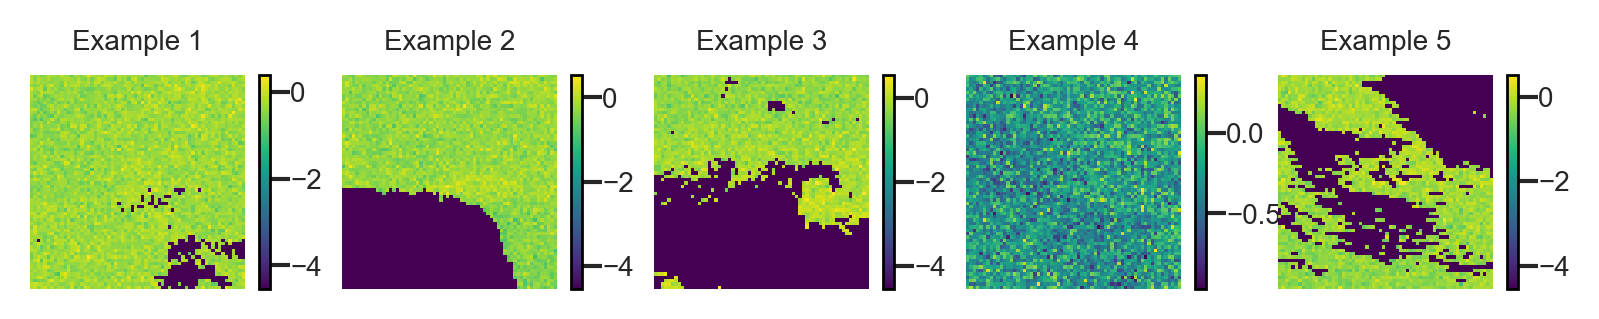

ic| np.sum(plot_data == np.median(plot_data)): 0
ic| np.median(plot_data): 0.0070366645
ic| np.sum(plot_data == np.median(plot_data)): 0
ic| np.median(plot_data): -0.084624976
ic| np.sum(plot_data == np.median(plot_data)): 0
ic| np.median(plot_data): -0.16769911
ic| np.sum(plot_data == np.median(plot_data)): 0
ic| np.median(plot_data): 0.099983804
ic| np.sum(plot_data == np.median(plot_data)): 0
ic| np.median(plot_data): 0.23717856


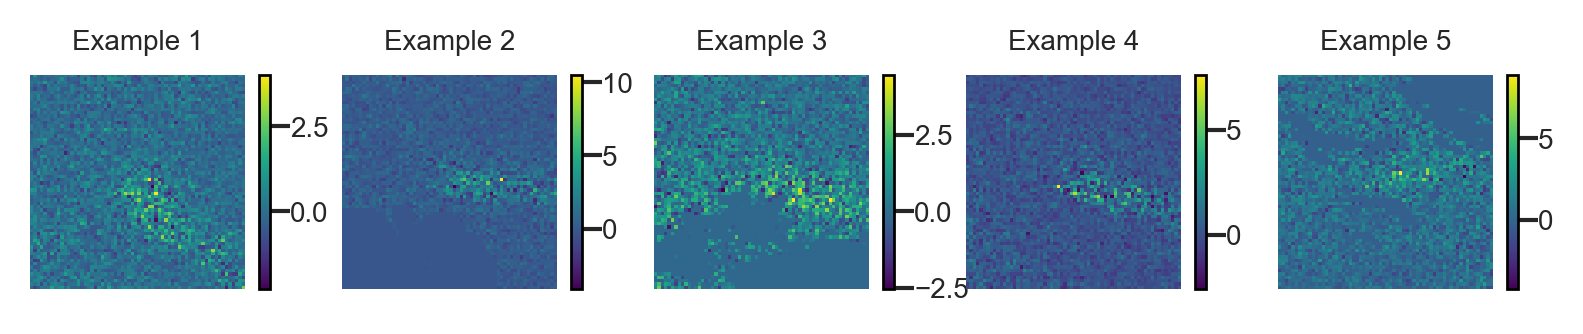

In [16]:
for i, idx in enumerate(example_indices):
    plot_data = outputs[idx, :, :, 0]

    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(plot_data, cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ic(np.sum(plot_data == np.min(plot_data)))
    plt.colorbar(im, cax=cax)
    ic(np.min(plot_data))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

for i, idx in enumerate(example_indices):
    plot_data = outputs[idx, :, :, 2]

    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(plot_data, cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ic(np.sum(plot_data == np.median(plot_data)))
    plt.colorbar(im, cax=cax)
    ic(np.median(plot_data))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

ic| np.sum(plot_data == np.min(plot_data)): 988
ic| np.median(plot_data): -0.34221786
ic| np.sum(plot_data == np.min(plot_data)): 1741
ic| np.median(plot_data): -0.41109684
ic| np.sum(plot_data == np.min(plot_data)): 2127
ic| np.median(plot_data): -0.5
ic| np.sum(plot_data == np.min(plot_data)): 510
ic| np.median(plot_data): -0.25688702
ic| np.sum(plot_data == np.min(plot_data)): 2037
ic| np.median(plot_data): -0.4934829


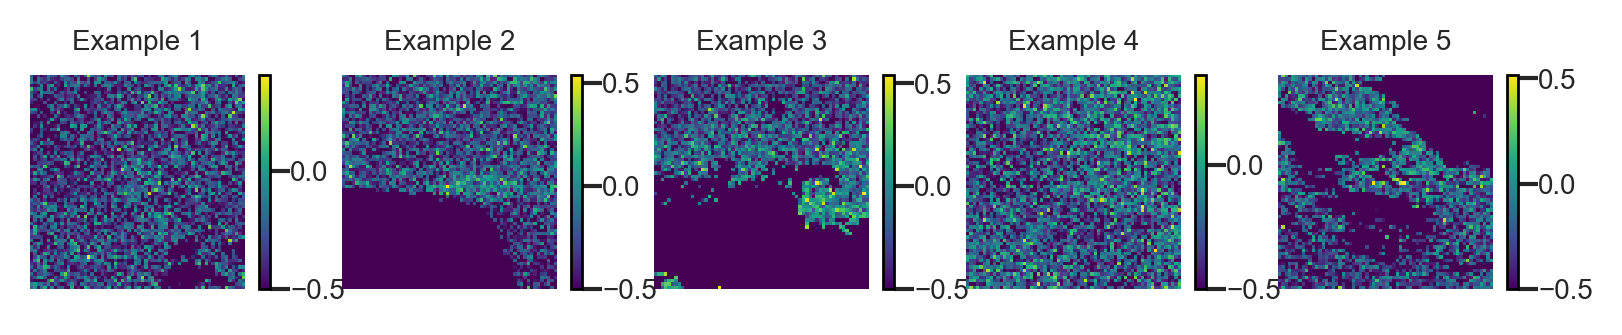

In [17]:
for i, idx in enumerate(example_indices):
    plot_data = outputs[idx, :, :, 0]
    plot_data = np.where(plot_data < -0.5, -0.5, plot_data)
    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(plot_data, cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ic(np.sum(plot_data == np.min(plot_data)))
    plt.colorbar(im, cax=cax)
    ic(np.median(plot_data))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

In [6]:
class ConditionalNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, noisy_chans, stddev=0.7, **kwargs):
        super().__init__(**kwargs)
        self.noisy_chans = noisy_chans
        self.stddev = stddev

    def call(self, inputs, training=None):
        if training:
            outputs = [None] * len(self.noisy_chans)
            for idx in range(len(self.noisy_chans)):
                if self.noisy_chans[idx]:
                    outputs[idx] = tf.keras.layers.GaussianNoise(
                        stddev=0.7, name=f"noise_{idx}"
                    )(inputs[:, :, :, idx : idx + 1])
                else:
                    outputs[idx] = tf.keras.layers.Layer()(
                        inputs[:, :, :, idx : idx + 1]
                    )
            return tf.keras.layers.Concatenate()(outputs)
        else:
            return inputs

In [7]:
def get_preprocessing_layers(
    noise_layer: ConditionalNoiseLayer,
    norm_layer: tf.keras.layers.Normalization,
    cloud_layer: CloudsLayer,
):
    """Return preprocessing layers for regression model."""

    def preproc_layers(x, training=None):
        x = noise_layer(x, training)
        x = norm_layer(x, training)
        x = cloud_layer(x, training)
        return x

    return preproc_layers

In [8]:
noise_layer = ConditionalNoiseLayer(data.x.xco2_noisy_chans)

In [9]:
pl = get_preprocessing_layers(noise_layer, data.x.n_layer, data.x.cloud_layer)

In [10]:
inputs = data.x.train[0:32]
outputs = pl(inputs)

In [11]:
array1_tensor = tf.constant(outputs)
difference = inputs - array1_tensor
tf.norm(difference)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [21]:
inputs = data.x.train[0:32]
outputs = pl(inputs, training=True)

In [84]:
chans = [None] * len(cloudy_chans)
random_indices = np.random.choice(
    clouds_array.shape[0], size=inputs.shape[0], replace=True
)
selected_clouds = clouds_array[random_indices]
clouded_fields = apply_clouds_to_field(inputs, cloudy_chans, selected_clouds)

In [80]:
chans = [None] * len(cloudy_chans)
random_indices = np.random.choice(
    clouds_array.shape[0], size=inputs.shape[0], replace=True
)
selected_clouds = clouds_array[random_indices]

In [81]:
field = inputs
clouds = selected_clouds

In [82]:
for idx, chan_name in enumerate(cloudy_chans):
    if chan_name in ["xco2", "no2"]:
        ic(chan_name)
        threshold = 0.01 if chan_name == "xco2" else 0.3
        bin_threshold = (clouds < threshold).astype(int)
        channel_data = field[:, :, :, idx]
        channel_data[bin_threshold == 0] = np.nan

        # Apply np.nanmin for 'xco2' and np.nanmedian for 'no2'
        nan_function = np.nanmin
        if chan_name == "no2":
            nan_function = np.nanmedian

        field[:, :, :, idx] = np.nan_to_num(
            channel_data, nan=nan_function(channel_data)
        )

ic| chan_name: 'xco2'
ic| chan_name: 'no2'


In [6]:
model.fit(
    data.x.train,
    data.y.train,
    epochs=2,
    validation_data=(data.x.valid, data.y.valid),
    verbose=1,
)

Epoch 1/2


AttributeError: in user code:

    File "/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filehognm6ou.py", line 43, in tf__call
        ag__.if_stmt(ag__.ld(training), if_body, else_body, get_state, set_state, ('do_return', 'retval_'), 2)
    File "/tmp/__autograph_generated_filehognm6ou.py", line 23, in if_body
        clouded_fields = ag__.converted_call(ag__.ld(apply_clouds_to_field), (ag__.ld(inputs), ag__.ld(self).cloudy_chans, ag__.ld(selected_clouds)), None, fscope)
    File "/tmp/__autograph_generated_file642dhhzf.py", line 46, in tf__apply_clouds_to_field
        ag__.for_stmt(ag__.converted_call(ag__.ld(enumerate), (ag__.ld(cloudy_chans),), None, fscope), None, loop_body, get_state_1, set_state_1, (), {'iterate_names': '(idx, chan_name)'})
    File "/tmp/__autograph_generated_file642dhhzf.py", line 38, in loop_body
        ag__.if_stmt(ag__.ld(chan_name) in ['xco2', 'no2'], if_body, else_body, get_state, set_state, ('list_tensor[idx]',), 1)
    File "/tmp/__autograph_generated_file642dhhzf.py", line 34, in if_body
        ag__.ld(list_tensor)[ag__.ld(idx)] = ag__.converted_call(ag__.ld(np).nan_to_num, (ag__.converted_call(ag__.ld(modified_channel_data).numpy, (), None, fscope),), dict(nan=ag__.converted_call(ag__.ld(nan_function), (ag__.converted_call(ag__.ld(modified_channel_data).numpy, (), None, fscope),), None, fscope)), fscope)

    AttributeError: Exception encountered when calling layer 'clouds_layer_1' (type CloudsLayer).
    
    in user code:
    
        File "/cerea_raid/users/dumontj/dev/coco2/inv/include/clouds.py", line 61, in call  *
            clouded_fields = apply_clouds_to_field(
        File "/cerea_raid/users/dumontj/dev/coco2/inv/include/clouds.py", line 34, in apply_clouds_to_field  *
            list_tensor[idx] = np.nan_to_num(
    
        AttributeError: 'SymbolicTensor' object has no attribute 'numpy'
    
    
    Call arguments received by layer 'clouds_layer_1' (type CloudsLayer):
      • inputs=tf.Tensor(shape=(32, 64, 64, 3), dtype=float32)
      • training=True
      • kwargs=<class 'inspect._empty'>
